### Quora Data Challenge
The data challenge simulates a typical experiment analysis you would be expected to work on at Quora. In this challenge, we will provide several datasets and ask you to analyze the results and provide product recommendations for a particular experiment. 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [3]:
user_active_min = pd.read_csv("t1_user_active_min.csv")
user_variant = pd.read_csv("t2_user_variant.csv")
user_active_min_pre = pd.read_csv("t3_user_active_min_pre.csv")
user_attributes = pd.read_csv("t4_user_attributes.csv")

In [4]:
"""
This table contains active minutes data logged after experiment started.
Each row represents the total number of minutes spent on site for each user on a date.
If a user never visited the site for a given date, there wouldn't be data for that uid on that date.
- uid: user ID
- dt: date when corresponding active minutes are registered
- active_mins: number of minutes spent on site for the date
"""
user_active_min.head(3)

uid          dt  active_mins
0    0  2019-02-22          5.0
1    0  2019-03-11          5.0
2    0  2019-03-18          3.0

In [5]:
"""
This table contains users‚Äô treatment assignment.
Each row represents the assignment information for a unique user.
- uid: user ID
- variant_number: the experiment variant user is in. 0 for control, 1 for treatment
- dt: date when user entered the experiment, should be ‚Äò2019-02-06‚Äô for all users
- signup_date: the date string that user signed up on"""

user_variant.head(3)

uid  variant_number          dt signup_date
0    0               0  2019-02-06  2018-09-24
1    1               0  2019-02-06  2016-11-07
2    2               0  2019-02-06  2018-09-17

In [6]:
"""
This table contains active minutes data before the experiment started.
It has a similar format as t1, except the dt range can extend before the experiment start date.
- uid: user ID
- dt: date when corresponding active minutes are registered
- active_mins: number of minutes spent on site for the date
"""
user_active_min_pre.head(3)

uid          dt  active_mins
0    0  2018-09-24          3.0
1    0  2018-11-08          4.0
2    0  2018-11-24          3.0

In [7]:
"""
This table contains data about some user attributes.
Each row represents attributes of a unique user.
- uid: user ID
- user_type: segment that a user belongs to, measured by activity level of the user. Can be ‚Äònew_user‚Äô, ‚Äònon_reader‚Äô, ‚Äòreader‚Äô or ‚Äòcontributor‚Äô
- gender: user gender. Can be ‚Äòmale‚Äô, ‚Äòfemale‚Äô or ‚Äòunknown‚Äô
"""
user_attributes .head(3)

uid gender   user_type
0    0   male  non_reader
1    1   male      reader
2    2   male  non_reader

In [8]:
"""
Let's see the total number of users in each tables and the number of dates 
"""

print(f' number of users in table user active mins {user_active_min["uid"].unique().__len__()}')
print(f' number of users in table user active mins pre experiment {user_active_min_pre["uid"].unique().__len__()}')
print(f' number of users in table user variant {user_variant["uid"].unique().__len__()}')
print(f' number of users in table user attributes {user_attributes["uid"].unique().__len__()}')
print(f' number of dates before experiment started  {user_active_min_pre["dt"].unique().__len__()}')
print(f' number of dates after started {user_active_min["dt"].unique().__len__()}')

 number of users in table user active mins 46633
 number of users in table user active mins pre experiment 49697
 number of users in table user variant 50000
 number of users in table user attributes 50000
 number of dates before experiment started  180
 number of dates after started 150


Now it is apparent to see that we have more users and more dates in the pre-experiment data, this is something to keep in mind as it could skew our calculations if we were to simply take total values of minutes spent on the Quora app. Even if one user spent x minutes everyday on the app pre-experiment and y minutes everyday post-experiment for some x < y, it could show as them spending more time pre-experiment, which would lead us to a false conclusion.

In [9]:
"""
i am removing the data points from pre_experiment table which are older than 5 months to keep the observation time scale balance
"""

user_active_min_pre['dt'] = pd.to_datetime(user_active_min_pre['dt'])
user_active_min['dt'] = pd.to_datetime(user_active_min['dt'])

In [10]:
user_variant['signup_date']= pd.to_datetime(user_variant['signup_date'])

<AxesSubplot:ylabel='Frequency'>

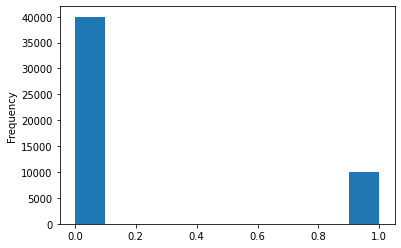

In [11]:
user_variant['variant_number'].plot(kind='hist')

In [158]:
x1=pd.DataFrame(user_variant[user_variant['variant_number']==0].groupby('signup_date').count()['dt'])#.plot(label='control group signup')
x2=pd.DataFrame(user_variant[user_variant['variant_number']==1].groupby('signup_date').count()['dt'])#.plot(ax=x1,label='treatment group signup')


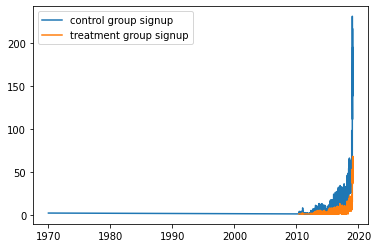

In [163]:
plt.plot(x1.index,x1.dt,label='control group signup')
plt.plot(x2.index,x2.dt,label='treatment group signup')
plt.legend()

In [164]:
# this shows that in terms of date the data is little bit  unbalanced 

### Joining user variant and attributes

In [14]:
x=user_active_min_pre.sort_values(by='dt')
print(x['dt'].unique()[29])
del x

2018-09-08T00:00:00.000000000


In [15]:
"""

Here i am omittiing all those records which are older than 5 months from start date of experiment because i am using total minutes 
per customer for the t test

"""
user_active_min_pre= user_active_min_pre[user_active_min_pre['dt']>pd.to_datetime("2018-09-08")]

In [165]:
user_active_min_pre['dt'].unique().__len__()

150

Now we see that both data frames are balanced with respect time frames

In [17]:
variant_attributes= pd.merge(user_variant,user_attributes,how='inner',on='uid')
variant_attributes.head()

uid  variant_number          dt signup_date gender   user_type
0    0               0  2019-02-06  2018-09-24   male  non_reader
1    1               0  2019-02-06  2016-11-07   male      reader
2    2               0  2019-02-06  2018-09-17   male  non_reader
3    3               0  2019-02-06  2018-03-04   male  non_reader
4    4               0  2019-02-06  2017-03-09   male  non_reader

<AxesSubplot:>

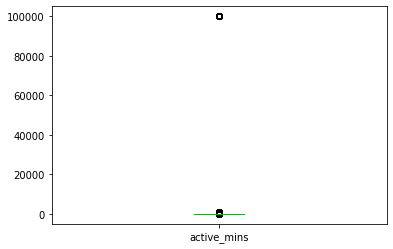

In [18]:
user_active_min['active_mins'].plot(kind='box')

### Outlier Treatment
There are some outliers in the data set
So I  am going to remove those data points which have active_time more than 24hrs 

In [19]:
user_active_min =user_active_min[user_active_min['active_mins']<24*60]
user_active_min_pre =user_active_min_pre[user_active_min_pre['active_mins']<24*60]

<AxesSubplot:>

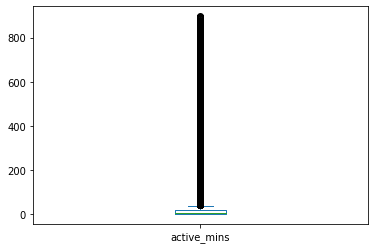

In [20]:
user_active_min['active_mins'].plot(kind='box')

Data is still having outliers so i am thinking to keep the data points between 5 and 95 percentiles

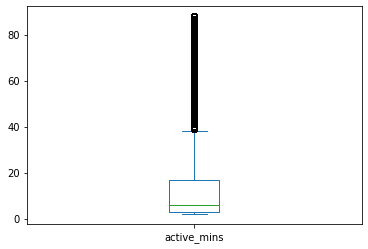

<AxesSubplot:>

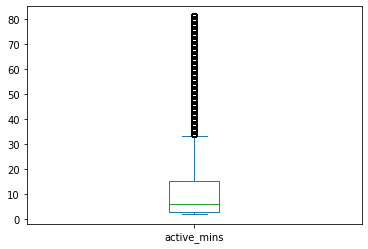

In [183]:
user_active_min[(user_active_min['active_mins']<user_active_min['active_mins'].quantile(.95))
                &(user_active_min['active_mins']>user_active_min['active_mins'].quantile(.05))
               ]['active_mins'].plot(kind='box')
plt.show()
user_active_min_pre[(user_active_min_pre['active_mins']<user_active_min_pre['active_mins'].quantile(.95))
                &(user_active_min_pre['active_mins']>user_active_min_pre['active_mins'].quantile(.05))
               ]['active_mins'].plot(kind='box')

In [184]:
user_active_min =user_active_min[(user_active_min['active_mins']<user_active_min['active_mins'].quantile(.95))
                &(user_active_min['active_mins']>user_active_min['active_mins'].quantile(.05))
               ]
user_active_min_pre =user_active_min_pre[(user_active_min_pre['active_mins']<user_active_min_pre['active_mins'].quantile(.95))
                &(user_active_min_pre['active_mins']>user_active_min_pre['active_mins'].quantile(.05))
               ]

In [185]:
user_active_min['dt'] = pd.to_datetime(user_active_min['dt'])

In [186]:
#user_active_min_pre.plot(x='dt',y='active_mins',kind='scatter')

In [187]:
print(user_active_min['active_mins'].describe())
print("===========================================")
print(user_active_min_pre['active_mins'].describe())

count    846408.000000
mean         13.845178
std          17.278389
min           2.000000
25%           3.000000
50%           6.000000
75%          17.000000
max          88.000000
Name: active_mins, dtype: float64
count    797514.000000
mean         12.539414
std          15.723006
min           2.000000
25%           3.000000
50%           6.000000
75%          15.000000
max          81.000000
Name: active_mins, dtype: float64


In [188]:
# The std and mean is having a lot of effect

In [189]:
uid_control         = list(variant_attributes[variant_attributes["variant_number"]==0]['uid'])
uid_treatment       = list(variant_attributes[variant_attributes["variant_number"]==1]['uid'])
before_AB_control   = user_active_min_pre[user_active_min_pre['uid'].isin(uid_control)]
before_AB_treatment = user_active_min_pre[user_active_min_pre['uid'].isin(uid_treatment)]
after_AB_control    = user_active_min[user_active_min['uid'].isin(uid_control)]
after_AB_treatment  = user_active_min[user_active_min['uid'].isin(uid_treatment)]

In [190]:
before_AB_control.head(5)

uid         dt  active_mins
0    0 2018-09-24          3.0
1    0 2018-11-08          4.0
2    0 2018-11-24          3.0
3    0 2018-11-28          6.0
4    0 2018-12-02          6.0

In [191]:
before_AB_control_base_table   = pd.merge(before_AB_control,variant_attributes, how = "inner", on = "uid")
before_AB_treatment_base_table = pd.merge(before_AB_treatment,variant_attributes, how = "inner", on = "uid")
after_AB_control_base_table    = pd.merge(after_AB_control,variant_attributes, how = "inner", on = "uid")
after_AB_treatment_base_table  = pd.merge(after_AB_treatment,variant_attributes, how = "inner", on = "uid")

In [192]:
before_AB_control_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
before_AB_treatment_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
after_AB_control_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
after_AB_treatment_base_table.rename(columns = {"dt_x":"date","dt_y":"AB_Date"}, inplace = True)
before_AB_control_base_table.head()

uid       date  active_mins  variant_number     AB_Date signup_date gender  \
0    0 2018-09-24          3.0               0  2019-02-06  2018-09-24   male   
1    0 2018-11-08          4.0               0  2019-02-06  2018-09-24   male   
2    0 2018-11-24          3.0               0  2019-02-06  2018-09-24   male   
3    0 2018-11-28          6.0               0  2019-02-06  2018-09-24   male   
4    0 2018-12-02          6.0               0  2019-02-06  2018-09-24   male   

    user_type  
0  non_reader  
1  non_reader  
2  non_reader  
3  non_reader  
4  non_reader

In [193]:
before_AB_control_base_table.head()

uid       date  active_mins  variant_number     AB_Date signup_date gender  \
0    0 2018-09-24          3.0               0  2019-02-06  2018-09-24   male   
1    0 2018-11-08          4.0               0  2019-02-06  2018-09-24   male   
2    0 2018-11-24          3.0               0  2019-02-06  2018-09-24   male   
3    0 2018-11-28          6.0               0  2019-02-06  2018-09-24   male   
4    0 2018-12-02          6.0               0  2019-02-06  2018-09-24   male   

    user_type  
0  non_reader  
1  non_reader  
2  non_reader  
3  non_reader  
4  non_reader

In [194]:
import seaborn as sns
import plotly.express as px
fig = px.histogram(before_AB_treatment_base_table, x="active_mins")
fig.show()

In [195]:
pd.DataFrame(before_AB_control_base_table['active_mins'].describe())

active_mins
count  662728.000000
mean       12.841476
std        16.001222
min         2.000000
25%         3.000000
50%         6.000000
75%        15.000000
max        81.000000

In [196]:
pd.DataFrame(before_AB_treatment_base_table['active_mins'].describe())

active_mins
count  134786.000000
mean       11.054204
std        14.183183
min         2.000000
25%         3.000000
50%         5.000000
75%        12.000000
max        81.000000

In [197]:
pd.DataFrame(after_AB_control_base_table['active_mins'].describe())

active_mins
count  697143.000000
mean       13.686436
std        17.275423
min         2.000000
25%         3.000000
50%         6.000000
75%        16.000000
max        88.000000

In [198]:
pd.DataFrame(after_AB_treatment_base_table['active_mins'].describe())

active_mins
count  149265.000000
mean       14.586581
std        17.272985
min         2.000000
25%         4.000000
50%         7.000000
75%        18.000000
max        88.000000

In [199]:
after_AB_treatment_base_table.sort_values(by = ['active_mins'], ascending=False)[:5]

uid       date  active_mins  variant_number     AB_Date signup_date  \
7231    40499 2019-05-14         88.0               1  2019-02-06  2014-01-14   
74861   45042 2019-04-24         88.0               1  2019-02-06  2018-06-19   
12347   40819 2019-03-16         88.0               1  2019-02-06  2018-08-18   
17142   41141 2019-05-09         88.0               1  2019-02-06  2013-10-16   
121996  48189 2019-04-15         88.0               1  2019-02-06  2018-07-25   

         gender   user_type  
7231    unknown      reader  
74861    female      reader  
12347      male  non_reader  
17142   unknown      reader  
121996   female  non_reader

<AxesSubplot:>

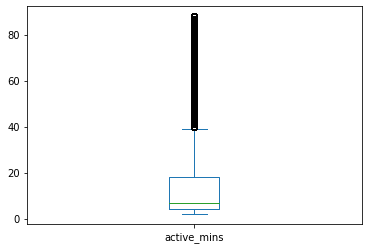

In [200]:
after_AB_treatment_base_table['active_mins'].plot(kind='box')

### T-Test Assumptions
 - The first assumption made regarding t-tests concerns the scale of measurement. The assumption for a t-test is that the scale of measurement applied to the data collected follows a continuous or ordinal scale, such as the scores for an IQ test.
 - The second assumption made is that of a simple random sample, that the data is collected from a representative, randomly selected portion of the total population.
 - The third assumption is the data, when plotted, results in a normal distribution, bell-shaped distribution curve. When a normal distribution is assumed, one can specify a level of probability (alpha level, level of significance, p) as a criterion for acceptance. In most cases, a 5% value can be assumed.
 - The fourth assumption is a reasonably large sample size is used. A larger sample size means the distribution of results should approach a normal bell-shaped curve.
 - The final assumption is homogeneity of variance. Homogeneous, or equal, variance exists when the standard deviations of samples are approximately equal.

#### Selection of unit for analysis


<AxesSubplot:xlabel='active_mins'>

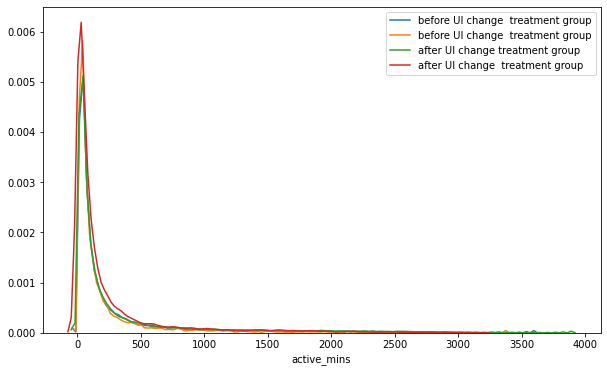

In [201]:

"""
Distribution of total minutes per user in each group 
(number of data points in each group = number of users in that group x number of days of the experiment)

"""
plt.figure(figsize=(10,6))
sns.distplot(before_AB_control_base_table.groupby('uid').sum()['active_mins'],hist = False,label ="before UI change  treatment group")
sns.distplot(before_AB_treatment_base_table.groupby('uid').sum()['active_mins'],hist = False,label ="before UI change  treatment group")
sns.distplot(after_AB_control_base_table.groupby('uid').sum()['active_mins'],hist = False,label ="after UI change treatment group")
sns.distplot(after_AB_treatment_base_table.groupby('uid').sum()['active_mins'],hist = False,label ="after UI change  treatment group")

<AxesSubplot:xlabel='active_mins'>

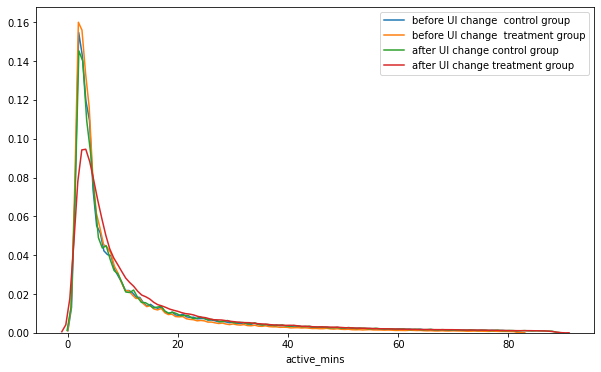

In [202]:

"""
avg minutes per user per day in distribution
(number of data points in each group = number of users in that group x number of days of the experiment)

"""

plt.figure(figsize=(10,6))
sns.distplot(before_AB_control_base_table['active_mins'],hist = False,label ="before UI change  control group")
sns.distplot(before_AB_treatment_base_table['active_mins'],hist = False,label ="before UI change  treatment group")
sns.distplot(after_AB_control_base_table['active_mins'],hist = False,label ="after UI change control group")
sns.distplot(after_AB_treatment_base_table['active_mins'],hist = False,label ="after UI change treatment group")

<AxesSubplot:xlabel='active_mins'>

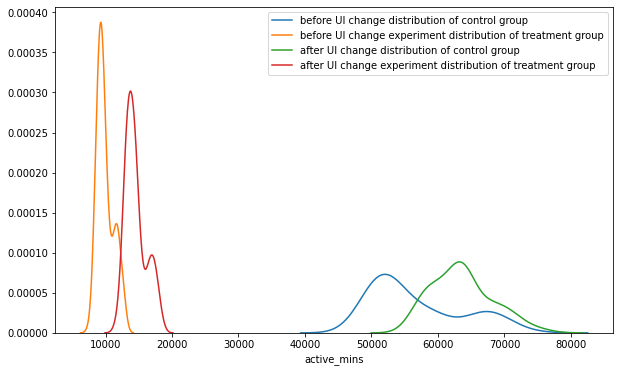

In [203]:

"""
Distribution of total minutes per day in each group 
(number of data points in each group = number of users in that group x number of days of the experiment)

"""
plt.figure(figsize=(10,6))
sns.distplot(before_AB_control_base_table.groupby('date').sum()['active_mins'],hist = False,label ="before UI change distribution of control group")
sns.distplot(before_AB_treatment_base_table.groupby('date').sum()['active_mins'],hist = False,label ="before UI change experiment distribution of treatment group")
sns.distplot(after_AB_control_base_table.groupby('date').sum()['active_mins'],hist = False,label ="after UI change distribution of control group")
sns.distplot(after_AB_treatment_base_table.groupby('date').sum()['active_mins'],hist = False,label ="after UI change experiment distribution of treatment group")

<AxesSubplot:xlabel='active_mins'>

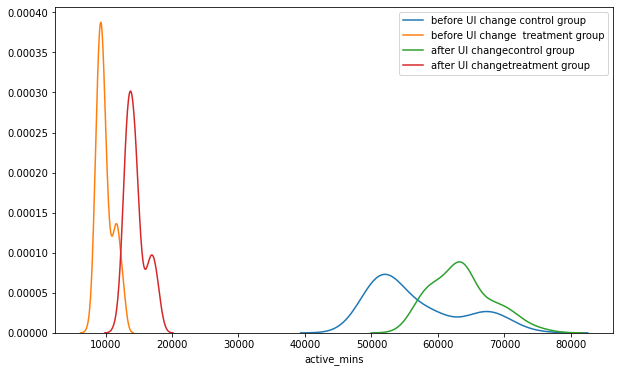

In [252]:
plt.figure(figsize=(10,6))
sns.distplot(before_AB_control_base_table.groupby('date').sum()['active_mins'],hist = False,label ="before UI change control group")
sns.distplot(before_AB_treatment_base_table.groupby('date').sum()['active_mins'],hist = False,label ="before UI change  treatment group")
sns.distplot(after_AB_control_base_table.groupby('date').sum()['active_mins'],hist = False,label ="after UI changecontrol group")
sns.distplot(after_AB_treatment_base_table.groupby('date').sum()['active_mins'],hist = False,label ="after UI changetreatment group")

<AxesSubplot:xlabel='active_mins'>

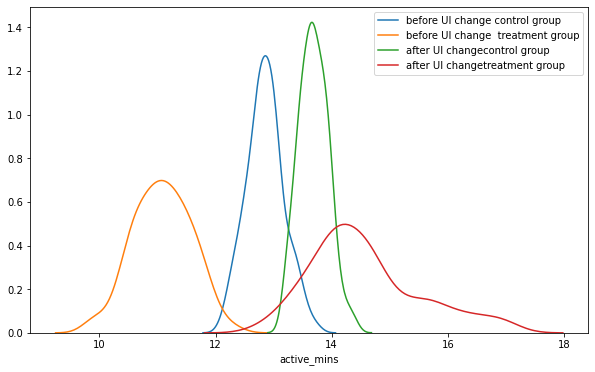

In [205]:

"""
Distribution of avg minutes per day per user in each group 
(number of data points in each group = number of users in that group x number of days of the experiment)
"""
plt.figure(figsize=(10,6))
sns.distplot(before_AB_control_base_table.groupby('date').mean()['active_mins'],hist = False,label ="before UI change control group")
sns.distplot(before_AB_treatment_base_table.groupby('date').mean()['active_mins'],hist = False,label ="before UI change  treatment group")
sns.distplot(after_AB_control_base_table.groupby('date').mean()['active_mins'],hist = False,label ="after UI changecontrol group")
sns.distplot(after_AB_treatment_base_table.groupby('date').mean()['active_mins'],hist = False,label ="after UI changetreatment group")

## The last sample plot of unit choice resembels more with population distribution (normal) 

Use only tables 1 (t1_user_active_min.csv) and 2 (t2_user_variant.csv) for this question. 

We suspect that there might be inaccuracies in the minutes spent on site data in some rows. Think about the definition of the metric and check if there are any outliers in the data. In this context, outliers mean numbers that are obviously different due to logging errors. If so, remove them; if not, use all the data. 

Using t-test under your assumption about variance, find an appropriate 95% confidence interval of the overall average treatment effect (using the unit of analysis you identified in the previous section).

Enter the confidence interval below. Please round your answer to second place after the decimal.

### Taking common users in both before and after experiment

In [254]:
common_treatment_uids= list(set(before_AB_treatment_base_table.uid.to_list()) and set(after_AB_treatment_base_table.uid.to_list()))
ids_df = pd.DataFrame(common_treatment_uids,columns=['uid'])

In [255]:
before_AB_treatment_base_table.__len__()

134786

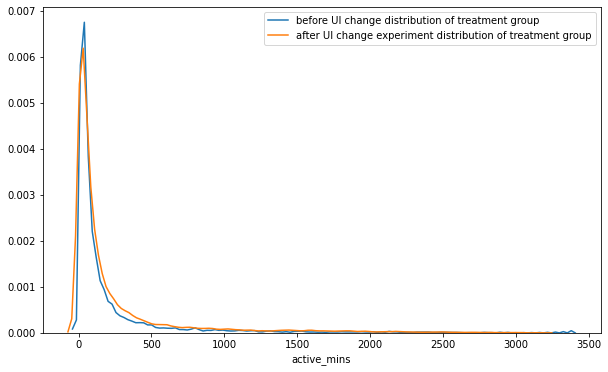

In [256]:
treatment_tabel_before = pd.merge(before_AB_treatment_base_table,ids_df,how='inner',on='uid').groupby('uid').sum()
treatment_tabel_after = pd.merge(after_AB_treatment_base_table,ids_df,how='inner',on='uid').groupby('uid').sum()


plt.figure(figsize=(10,6))
sns.distplot(treatment_tabel_before['active_mins'],hist = False,label ="before UI change distribution of treatment group")
sns.distplot(treatment_tabel_after['active_mins'],hist = False,label ="after UI change experiment distribution of treatment group")
plt.show()


In [258]:
common_control_uids= list(set(before_AB_control_base_table.uid.to_list()) and set(after_AB_control_base_table.uid.to_list()))
ids_df = pd.DataFrame(common_control_uids,columns=['uid'])

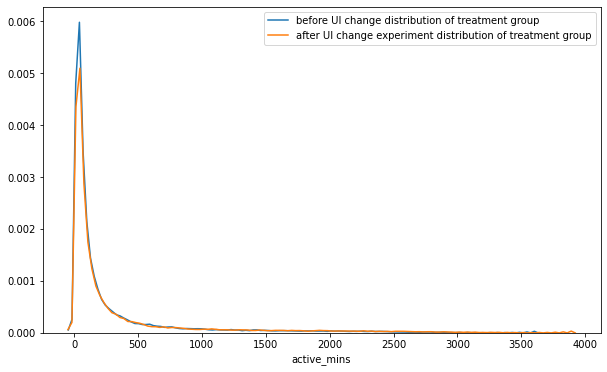

In [259]:
control_tabel_before = pd.merge(before_AB_control_base_table,ids_df,how='inner',on='uid').groupby('uid').sum()
control_tabel_after = pd.merge(after_AB_control_base_table,ids_df,how='inner',on='uid').groupby('uid').sum()

plt.figure(figsize=(10,6))
sns.distplot(control_tabel_before['active_mins'],hist = False,label ="before UI change distribution of treatment group")
sns.distplot(control_tabel_after['active_mins'],hist = False,label ="after UI change experiment distribution of treatment group")
plt.show()


In [260]:
treatment_tabel_before.__len__()

8830

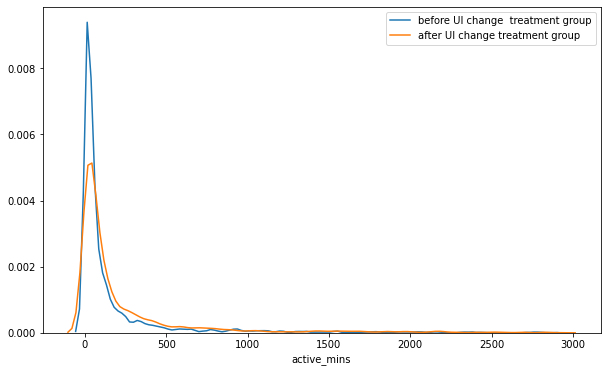

In [280]:

plt.figure(figsize=(10,6))
sns.distplot(treatment_tabel_before[:2000]['active_mins'],hist = False,label ="before UI change  treatment group")
sns.distplot(treatment_tabel_after[:2000]['active_mins'],hist = False,label ="after UI change treatment group")
# sns.distplot(control_tabel_before['active_mins'],hist = False,label ="before UI change control group")
# sns.distplot(control_tabel_after['active_mins'],hist = False,label ="after UI change control group")
plt.show()

`The (unreported) null hypothesis is
ùêª0: ùúá1 ‚àí ùúá2 = Hypothesized Difference = 0
and the alternative hypotheses,
ùêªùëé: ùúá1 ‚àí ùúá2 ‚â† Hypothesized Difference = 0
ùêªùëé: ùúá1 ‚àí ùúá2 < Hypothesized Difference = 0
ùêªùëé: ùúá1 ‚àí ùúá2 > Hypothesized Difference = 0
Since the Hypothesized Difference is zero in this example, the null and alternative hypotheses can be simplified to
Null hypothesis:
ùêª0: ùúá1 = ùúá2
Alternative hypotheses:
ùêªùëé: ùúá1 ‚â† ùúá2 ,
ùêªùëé: ùúá1 < ùúá2 , or
ùêªùëé: ùúá1 > ùúá2 .
In practice, the alternative hypothesis should be chosen in advance.`

In [281]:
from scipy import stats

In [283]:
import math
def confidence_interval_means(A, B, z=1.96):
    A_mean = A.mean()
    B_mean = B.mean()
    A_std = A.std()
    B_std = B.std()
    pool_std = math.sqrt((A_std + B_std) / 2)
    temp = A_mean - B_mean
    temp2 = z*pool_std*math.sqrt(1/A.count() + 1/B.count())
    return [temp - temp2,temp + temp2]



<p>Hypothesis

null -> mean_treatment=mean_control                      <br>
alternate1 -> mean_treatment>mean_control :t-statistic >0 <br>
alternate2 -> mean_treatment<mean_control :t-statistic <0 </p>




In [309]:
def t_stat_ci(a,b):
    x=stats.ttest_ind_from_stats(a.mean(),
                              a.std(),
                              a.__len__(),
                              b.mean(),
                              b.std(),
                              b.__len__(),
                              equal_var=False
                              )
    y= confidence_interval_means(a,b)
    print(f"t-statistic : {x}  \nconfidence interval: {y}")

In [312]:
t_stat_ci(treatment_tabel_after['active_mins'],control_tabel_after['active_mins'])

t-statistic : Ttest_indResult(statistic=-3.9487210920590536, pvalue=7.889696030387284e-05)  
confidence interval: [-22.15439995510434, -21.130059153030913]


 P value indicates that null hypothesis is invalid and statistic indicates that alternate2 hypothesis is true 
 

In [313]:
t_stat_ci(pd.concat([control_tabel_after,treatment_tabel_after])['active_mins'],
          pd.concat([control_tabel_before,treatment_tabel_before])['active_mins'])

t-statistic : Ttest_indResult(statistic=10.78415714703143, pvalue=4.251360783614677e-27)  
confidence interval: [35.13144591779709, 35.711126466305736]


#### The above result shows the overall distribution has shifted toward more active time 

In [314]:
t_stat_ci(treatment_tabel_before['active_mins'],control_tabel_before['active_mins'])

t-statistic : Ttest_indResult(statistic=-15.001069452390675, pvalue=1.509858364571709e-50)  
confidence interval: [-69.73425670130662, -68.77943170798447]


#### The above result shows that treatment group already had less mean than control group before the start of experiment 

In [318]:
t_stat_ci(treatment_tabel_after['active_mins'],control_tabel_before['active_mins'])

t-statistic : Ttest_indResult(statistic=0.8190018999581834, pvalue=0.41279856111513247)  
confidence interval: [3.858643020876475, 4.849254737396545]


In [315]:
t_stat_ci(control_tabel_after['active_mins'],control_tabel_before['active_mins'])

t-statistic : Ttest_indResult(statistic=6.8249785306218875, pvalue=8.863992213676039e-12)  
confidence interval: [25.666248972568972, 26.3261078938393]


In [316]:
t_stat_ci(treatment_tabel_after['active_mins'],treatment_tabel_before['active_mins'])

t-statistic : Ttest_indResult(statistic=12.126823466720774, pvalue=1.0427612296492953e-33)  
confidence interval: [73.02129759118839, 74.20028857637573]


The treatment group was already had less mean in comparision to control , but i have to find out the effect of new UI accuratly  so have good base of comparision i am combining treatment and control group before experiment

In [321]:
t_stat_ci(treatment_tabel_after['active_mins'],
          pd.concat([control_tabel_before,treatment_tabel_before])['active_mins'])

t-statistic : Ttest_indResult(statistic=3.507932013113475, pvalue=0.00045310486406542074)  
confidence interval: [17.60944464510179, 18.56972279229707]


In real life, experiment results can be nuanced. We provide you now additionally table 4 (t4_user_attributes.csv), which might help you analyze the results better. You should think about the context of the experiment and hypothesize why the analysis above could be insufficient. Explore the data and share with us your insights!

1. Given the new tables, were there any issues in treatment assignment? Was the treatment effect different for different covariates? 

2. Based on the new findings, what is your conclusion and what product recommendations would you make to the team?

Summarize your findings in a brief write-up with up to 200 words, and include one or two plots that best represent your results. Submit a single PDF file, please.

In [249]:
def build_dist(df,df1,col,col1,xlabelvalue,label1,label2):
    sns.distplot(df[col], hist=False, label = label1, axlabel = xlabelvalue)
    sns.distplot(df1[col1], hist=False, label = label2, axlabel = xlabelvalue)
    plt.show()

In [250]:
d1 =before_AB_control_base_table
d2 =after_AB_control_base_table
d3 =before_AB_treatment_base_table
d4 =after_AB_treatment_base_table

In [251]:
user_type=before_AB_treatment_base_table['user_type'].unique()

By Gender & User Type
Note that each co-variate group's graphs will be shown in the form:

- Experimental group before and after the experiment
- Control vs Experimental groups after the experiment
and that the title on the x-axis is the title of the graph, it's actually plotted as the number of minutes on the x-axis and the inverse of the count on the y-axis (it's a histogram just without the bars). It's just showing probability distributions so sometimes they will go negative too even though it's not possible to have negative minutes spent on the app.

In [63]:
def plot_gender_vs_user_type(d1,d2,gender,user_type,group,plot_type='dist'):
    if plot_type=='dist':
        sns.distplot(d1[(d1['gender']==gender)&(d1['user_type']==user_type)].groupby('date').mean()['active_mins'],
                     hist = False,
                     label =f"{group} {user_type} {gender} before exp"
                    )
        sns.distplot(d2[(d2['gender']==gender)&(d2['user_type']==user_type)].groupby('date').mean()['active_mins'],
                     hist = False,
                     label =f"{group}   {user_type} {gender} after exp")
    if plot_type =='box':
        d1[(d1['gender']==gender)&(d1['user_type']==user_type)].groupby('date').mean()['active_mins'].plot()
        
        

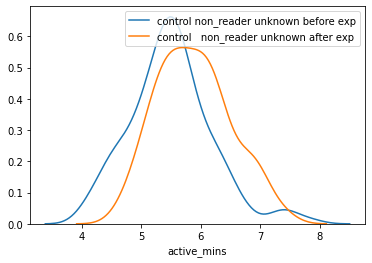

In [64]:
plot_gender_vs_user_type(d1,d2,'unknown','non_reader','control')

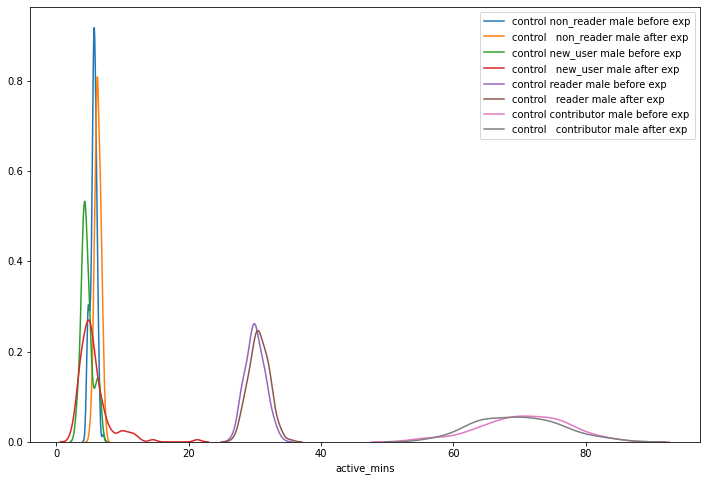

In [65]:
plt.figure(figsize=(12,8))
for type in user_type:
    plot_gender_vs_user_type(d1,d2,'male',type,'control')

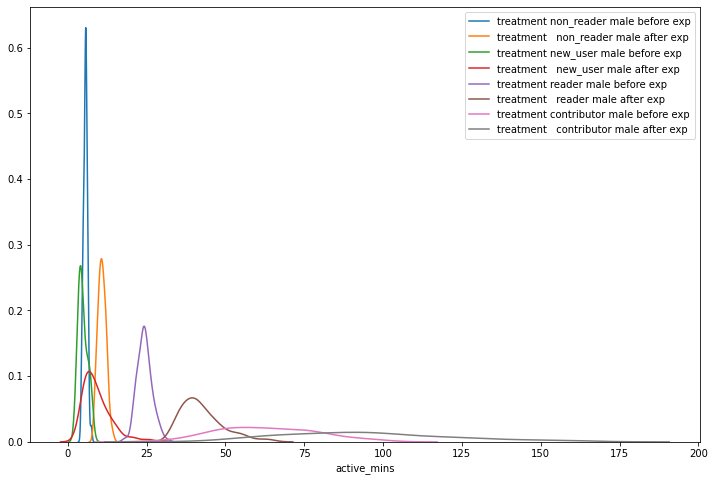

In [66]:
plt.figure(figsize=(12,8))
for type in user_type:
    plot_gender_vs_user_type(d3,d4,'male',type,'treatment')




After comparing the control group of pre-experiment data and post-experiment control group data i came to a conclusion that there was no effect of time over the 10 months because when i compared both control data's with t-test the p-value was near 0.45 which shows that both data are nearly same. But when I compared treatment (post experiment) with data (pre experiment both treatment + control = complete population) the lower and upper bounds of confidence interval got increased with respect to previous bounds which shows that the UI change had larger effect than which i previously thought

t-test

Text(0.5, 0, 'minutes per user per day')

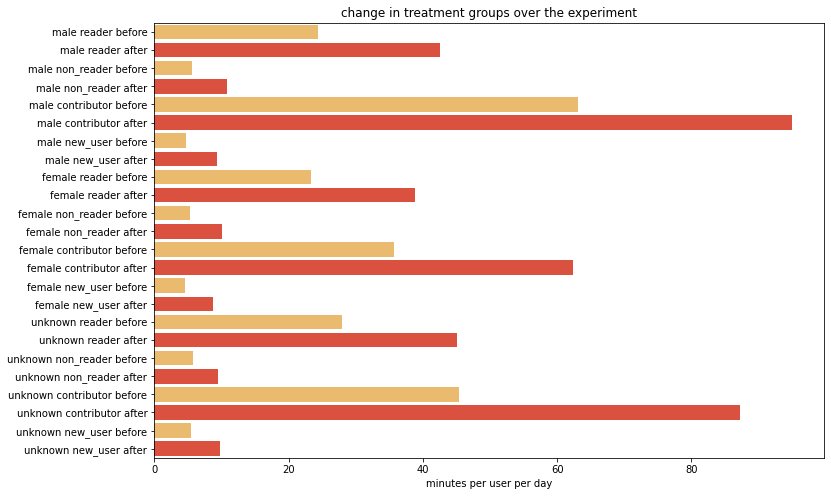

In [67]:
genders = ['male','female','unknown']
user_types= ['reader','non_reader','contributor','new_user']

data = pd.DataFrame()

for gender in genders:
    for user_type in user_types:
        data[f'{gender} {user_type} before'] = d3[(d3['gender']==gender)&(d3['user_type']==user_type)].groupby('date',as_index=False).mean()['active_mins']
        data[f'{gender} {user_type} after'] = d4[(d4['gender']==gender)&(d4['user_type']==user_type)].groupby('date',as_index=False).mean()['active_mins']

df=pd.DataFrame(data.mean(),columns=['mean'])
plt.figure(figsize=(12,8))
plt.title("change in treatment groups over the experiment")
sns.barplot(x=df['mean'],y=df.index,palette = sns.color_palette("YlOrRd", 2))
plt.xlabel("minutes per user per day")

Text(0.5, 0, 'minutes per user per day')

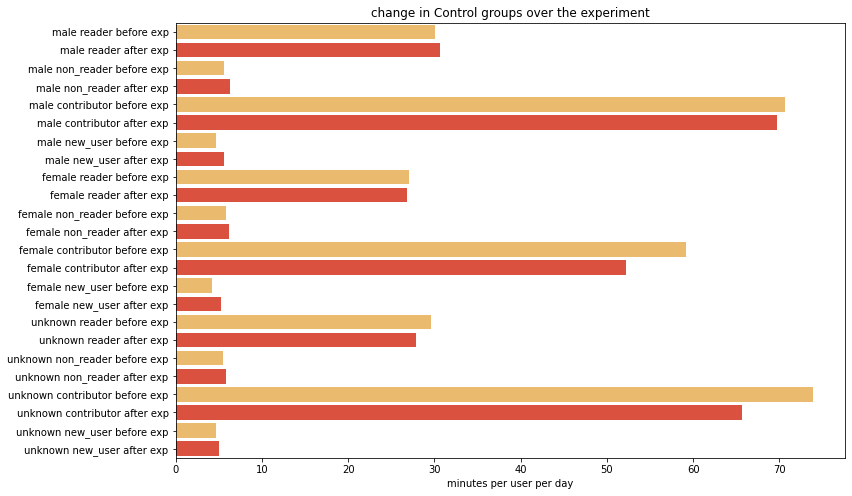

In [68]:
genders = ['male','female','unknown']
user_types= ['reader','non_reader','contributor','new_user']
data = pd.DataFrame()

for gender in genders:
    for user_type in user_types:
        data[f'{gender} {user_type} before exp'] = d1[(d1['gender']==gender)&(d1['user_type']==user_type)].groupby('date',as_index=False).mean()['active_mins']
        data[f'{gender} {user_type} after exp'] = d2[(d2['gender']==gender)&(d2['user_type']==user_type)].groupby('date',as_index=False).mean()['active_mins']


df=pd.DataFrame(data.mean(),columns=['mean'])
plt.figure(figsize=(12,8))
plt.title("change in Control groups over the experiment")
sns.barplot(x=df['mean'],y=df.index,palette = sns.color_palette("YlOrRd", 2))
plt.xlabel("minutes per user per day")

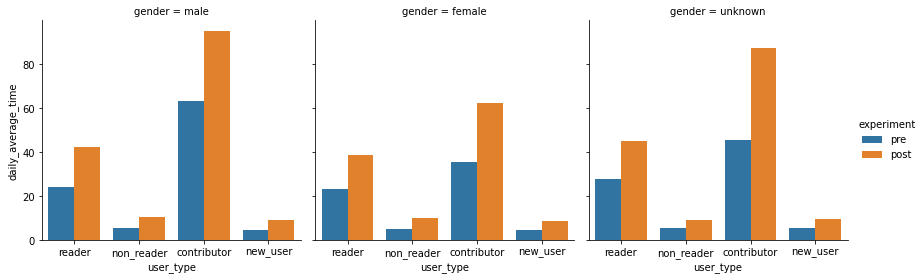

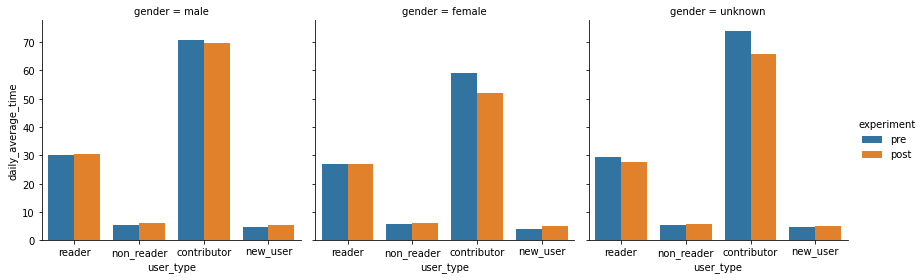

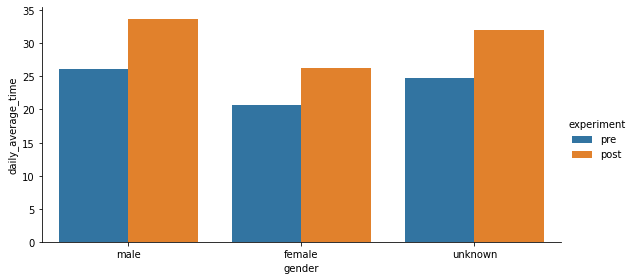

In [112]:
df1 =pd.DataFrame(columns=['user_type','gender','daily_average_time','experiment','group'])

for gender in genders:
    for user_type in user_types:
        row = {}
        row['user_type']= user_type
        row['gender']=gender
        row['daily_average_time']= d1[(d1['gender']==gender)&(d1['user_type']==user_type)].groupby('date',as_index=False).mean()['active_mins'].mean()
        row['experiment']='pre'
        row['group']=0
        df1=df1.append(row,ignore_index=True)
        row['daily_average_time']= d2[(d2['gender']==gender)&(d2['user_type']==user_type)].groupby('date',as_index=False).mean()['active_mins'].mean()
        row['experiment']='post'
        row['group']=0
        df1=df1.append(row,ignore_index=True)
        row['daily_average_time']= d3[(d3['gender']==gender)&(d3['user_type']==user_type)].groupby('date',as_index=False).mean()['active_mins'].mean()
        row['experiment']='pre'
        row['group']=1
        df1=df1.append(row,ignore_index=True)
        row['daily_average_time']= d4[(d4['gender']==gender)&(d4['user_type']==user_type)].groupby('date',as_index=False).mean()['active_mins'].mean()
        row['experiment']='post'
        row['group']=1
        df1=df1.append(row,ignore_index=True)
        
sns.catplot(x="user_type", y="daily_average_time", hue="experiment",col='gender', data=df1[df1['group']==1], ci=None,kind="bar",
                 height=4, aspect=1)


sns.catplot(x="user_type", y="daily_average_time", hue="experiment",col='gender', data=df1[df1['group']==0], ci=None,kind="bar",
                 height=4, aspect=1)

sns.catplot(x="gender", y="daily_average_time", hue="experiment", data=df1, ci=None,kind="bar",
                 height=4, aspect=2
           )

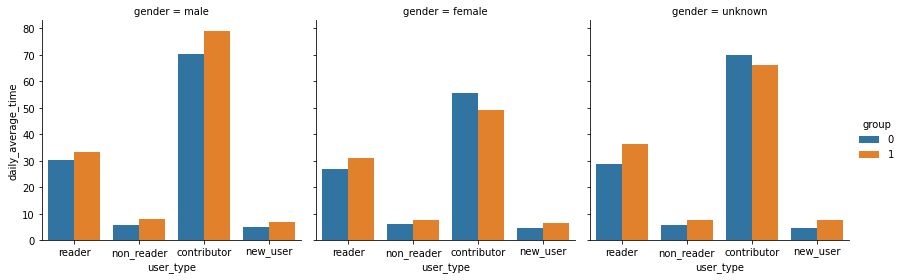

In [113]:
sns.catplot(x="user_type", y="daily_average_time", hue="group",col='gender', data=df1, ci=None,kind="bar",
                 height=4, aspect=1)

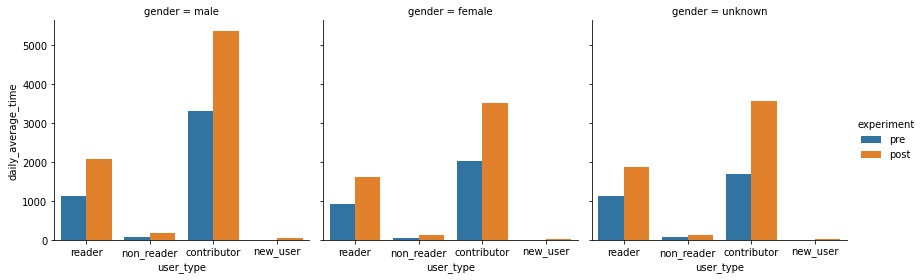

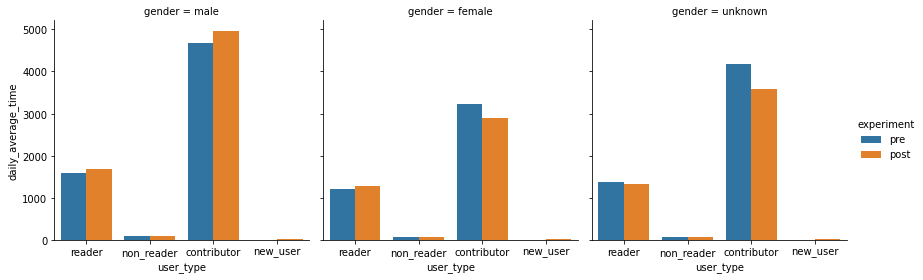

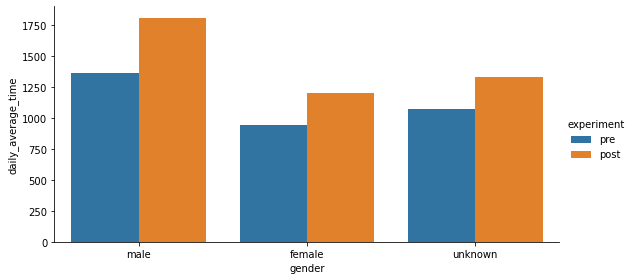

In [109]:
df1 =pd.DataFrame(columns=['user_type','gender','daily_average_time','experiment','group'])

for gender in genders:
    for user_type in user_types:
        row = {}
        row['user_type']= user_type
        row['gender']=gender
        row['daily_average_time']= d1[(d1['gender']==gender)&(d1['user_type']==user_type)].groupby('uid',as_index=False).sum()['active_mins'].mean()
        row['experiment']='pre'
        row['group']=0
        df1=df1.append(row,ignore_index=True)
        row['daily_average_time']= d2[(d2['gender']==gender)&(d2['user_type']==user_type)].groupby('uid',as_index=False).sum()['active_mins'].mean()
        row['experiment']='post'
        row['group']=0
        df1=df1.append(row,ignore_index=True)
        row['daily_average_time']= d3[(d3['gender']==gender)&(d3['user_type']==user_type)].groupby('uid',as_index=False).sum()['active_mins'].mean()
        row['experiment']='pre'
        row['group']=1
        df1=df1.append(row,ignore_index=True)
        row['daily_average_time']= d4[(d4['gender']==gender)&(d4['user_type']==user_type)].groupby('uid',as_index=False).sum()['active_mins'].mean()
        row['experiment']='post'
        row['group']=1
        df1=df1.append(row,ignore_index=True)
        
sns.catplot(x="user_type", y="daily_average_time", hue="experiment",col='gender', data=df1[df1['group']==1], ci=None,kind="bar",
                 height=4, aspect=1)


sns.catplot(x="user_type", y="daily_average_time", hue="experiment",col='gender', data=df1[df1['group']==0], ci=None,kind="bar",
                 height=4, aspect=1)

sns.catplot(x="gender", y="daily_average_time", hue="experiment", data=df1, ci=None,kind="bar",
                 height=4, aspect=2
           )